In [16]:
import os
import pandas as pd
import json
import glob
from matplotlib import pyplot as plt
from scipy.integrate import trapezoid
import seaborn as sns
import numpy as np

In [17]:
plt.rcParams["font.family"] = "serif"

In [18]:
def process_power_per_pod(folder_path):
    # Process power consumption data
    power_file = os.path.join(folder_path, "metrics_energy.json")
    uid_pod_map_file = os.path.join(folder_path, "uid_pod_mapping.csv")  # Now reading as a CSV

    # Load UID to Pod Name Mapping
    if os.path.exists(uid_pod_map_file):
        uid_pod_map = pd.read_csv(uid_pod_map_file)  # Read CSV into a DataFrame
        # Ensure the mapping DataFrame has expected columns
        if not {"UID", "Pod Name"}.issubset(uid_pod_map.columns):
            print("Invalid UID-Pod mapping format")
            return pd.DataFrame()  # Return an empty DataFrame
    else:
        print("No UID-Pod mapping file found")
        return pd.DataFrame()  # Return an empty DataFrame

    # Load Power Data
    if os.path.exists(power_file):
        with open(power_file, 'r') as f:
            power_data = json.load(f)
    else:
        print("No power data file found")
        return pd.DataFrame()  # Return an empty DataFrame
       
    # Collect timestamps and values for all pods
    rows = []
    for uid_suffix, data in power_data.items():
        # Map UID suffix to pod name using the DataFrame
        pod_name_row = uid_pod_map[uid_pod_map["UID"].str.endswith(uid_suffix)]
        if pod_name_row.empty:
            continue  # Skip if no matching UID is found
        pod_name = pod_name_row.iloc[0]["Pod Name"]  # Get the first match

        # Append each entry in the pod's power data to the rows list
        for entry in data:
            rows.append({
                "timestamp": entry["timestamp"],
                "pod_name": pod_name,
                "value": entry["value"]
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(rows)

    return df


In [19]:
def process_folder(folder_path):
    # Extract configuration from folder name
    folder_name = os.path.basename(folder_path)
    requested_mbps, packet_length = folder_name.split('_')

    # Initialize results
    tot_mbps_received = 0  # Default if no files found
    server_durations = []  # List to store durations of all servers

    # Process iperf server log
    server_files = glob.glob(os.path.join(folder_path, "log_iperf_server_*.csv"))
    if server_files:
        for server_file in server_files:
            df_server = pd.read_csv(server_file)
            if not df_server.empty:
                # Extract the last row
                last_row = df_server.iloc[-1]
                
                # Extract Mbps from the last row
                tot_mbps_received += last_row['Transfer'] / 1e6  # Convert bps to Mbps
                
                # Extract and calculate duration from the Interval column
                interval_str = last_row['Interval']  # Example: '0.0-3.1'
                start, end = map(float, interval_str.split('-'))  # Split into start and end times
                duration = end - start  # Calculate duration
                server_durations.append(duration)  # Store the duration for this server

    # Process pod-level power data using process_power_per_pod
    df_pod_power = process_power_per_pod(folder_path)

    # Initialize aggregated power and energy consumption variables
    power_components = ['oai-cu', 'oai-du', 'oai-nr-ue', 'oai-upf']
    power_results = {component: {'baseline': 0, 'experiment': 0} for component in power_components}
    energy_results = {component: {'baseline': 0, 'experiment': 0} for component in power_components}

    # Aggregate power and energy consumption per component
    for component in power_components:
        component_pods = df_pod_power[df_pod_power["pod_name"].str.startswith(component)]
        if not component_pods.empty:
            component_pods_sorted = component_pods.sort_values(by="timestamp")
            baseline_filtered = component_pods_sorted.iloc[20:40]
            experiment_filtered = component_pods_sorted.iloc[-int(round(min(server_durations), 0)):]  # Use min duration for slicing

            # Aggregate power and energy for all pods belonging to the same component
            baseline_power_avg = baseline_filtered['value'].mean() if not baseline_filtered.empty else 0
            experiment_power_avg = experiment_filtered['value'].mean() if not experiment_filtered.empty else 0

            power_results[component]['baseline'] += baseline_power_avg
            power_results[component]['experiment'] += experiment_power_avg

            # Calculate energy as the integral of power over time (assuming equal time intervals)
            baseline_energy = trapezoid(baseline_filtered['value'], dx=1) if not baseline_filtered.empty else 0
            experiment_energy = trapezoid(experiment_filtered['value'], dx=1) if not experiment_filtered.empty else 0

            # If energy calculation is not valid, fallback to power × duration
            if experiment_energy <= 0:
                experiment_energy = experiment_power_avg * sum(server_durations)

            energy_results[component]['baseline'] += baseline_energy
            energy_results[component]['experiment'] += experiment_energy

    # Combine CPU usage (if applicable) for each component
    cpu_usages = {}
    cpu_file = os.path.join(folder_path, "metrics_cpu.json")
    if os.path.exists(cpu_file):
        with open(cpu_file, 'r') as f:
            cpu_data = json.load(f)
        
        # Aggregate CPU usage per component
        for pod_name, pod_data in cpu_data.items():
            component = next((comp for comp in power_components if pod_name.startswith(comp)), None)
            if component:
                cpu_usages.setdefault(component, [])
                for entry in pod_data:
                    cpu_usages[component].append(entry['value'])

    avg_cpu_usage = {comp: (sum(values) / len(values) if values else 0) for comp, values in cpu_usages.items()}

    # Combine the results into a single row for baseline and experiment
    baseline = {
        "Mbps requested": int(requested_mbps),
        "packet length requested": int(packet_length),
        "tot Mbps effectively received at server": tot_mbps_received,
    }
    experiment = {
        "Mbps requested": int(requested_mbps),
        "packet length requested": int(packet_length),
        "tot Mbps effectively received at server": tot_mbps_received,
    }

    # Add power, energy, and CPU consumption data to baseline and experiment
    for component in power_components:
        # Add power consumption data
        baseline[f"avg {component.upper()} power consumption [W]"] = power_results[component]['baseline']
        experiment[f"avg {component.upper()} power consumption [W]"] = power_results[component]['experiment']

        # Add energy consumption data
        baseline[f"total {component.upper()} energy consumption [J]"] = energy_results[component]['baseline']
        experiment[f"total {component.upper()} energy consumption [J]"] = energy_results[component]['experiment']

        # Add CPU usage data, if available
        if component in avg_cpu_usage:
            baseline[f"avg {component.upper()} CPU usage [%]"] = avg_cpu_usage[component]
            experiment[f"avg {component.upper()} CPU usage [%]"] = avg_cpu_usage[component]
    for (i,duration) in enumerate(server_durations):
        # Add durations data
        experiment[f"duration_{i+1}"] = duration


    return baseline, experiment


In [20]:
def gather_metrics_all_rates(base_folder_path):
    data_baseline = []
    data_experiment = []

    # Iterate through all maxrate levels
    for maxrate_folder in os.listdir(base_folder_path):
        maxrate_path = os.path.join(base_folder_path, maxrate_folder)

        # Check if the maxrate path is a directory
        if not os.path.isdir(maxrate_path):
            continue

        # Iterate through all pools of experiments under the maxrate level
        for experiment_pool in os.listdir(maxrate_path):
            pool_path = os.path.join(maxrate_path, experiment_pool)

            # Check if the pool path is a directory
            if not os.path.isdir(pool_path):
                continue

            # Process each folder inside the pool
            for experiment_folder in os.listdir(pool_path):
                experiment_path = os.path.join(pool_path, experiment_folder)

                if os.path.isdir(experiment_path):  # Check if it's a directory
                    # Traverse deeper into the experiment folder for specific experiments
                    for subfolder in os.listdir(experiment_path):
                        subfolder_path = os.path.join(experiment_path, subfolder)

                        if os.path.isdir(subfolder_path):  # Check if it's a directory
                            # Extract CU information from the parent folder name
                            parent_folder_name = os.path.basename(pool_path)

                            try:
                                num_cus = int(parent_folder_name.split('_')[2][0])  # Extract the number of CUs
                            except (IndexError, ValueError):
                                print(f"Could not extract CU information from folder: {parent_folder_name}")
                                continue

                            # Process the subfolder and get baseline and experiment data
                            baseline, experiment = process_folder(subfolder_path)

                            # Add metadata to the results
                            baseline['maxrate'] = int(maxrate_folder)
                            experiment['maxrate'] = int(maxrate_folder)
                            baseline['experiment_pool'] = experiment_pool
                            experiment['experiment_pool'] = experiment_pool
                            baseline['num_cus'] = num_cus
                            experiment['num_cus'] = num_cus

                            # Append baseline and experiment data to their respective lists
                            data_baseline.append(baseline)
                            data_experiment.append(experiment)

    # Combine baseline and experiment data into DataFrames
    df_baseline = pd.DataFrame(data_baseline)
    df_experiment = pd.DataFrame(data_experiment)

    if not df_baseline.empty:
        df_baseline = df_baseline.select_dtypes(include=[float, int])  # Keep only numeric columns
        baseline_stats = df_baseline.agg(['mean', 'std']).T
    else:
        baseline_stats = pd.DataFrame()

    if not df_experiment.empty:
        df_experiment = df_experiment.select_dtypes(include=[float, int])  # Keep only numeric columns
        experiment_stats = df_experiment.agg(['mean', 'std']).T
    else:
        experiment_stats = pd.DataFrame()

    return df_baseline, df_experiment, baseline_stats, experiment_stats


# Example usage
base_folder_path = "/home/pow_cons/power-consumption-tool/power-metrics-per-pod-realtime/data/maxrate3"

df_baseline, df_experiment, baseline_stats, experiment_stats = gather_metrics_all_rates(base_folder_path)

# Filter data if needed
df_experiment_filtered = df_experiment[df_experiment['packet length requested'].isin([500])]

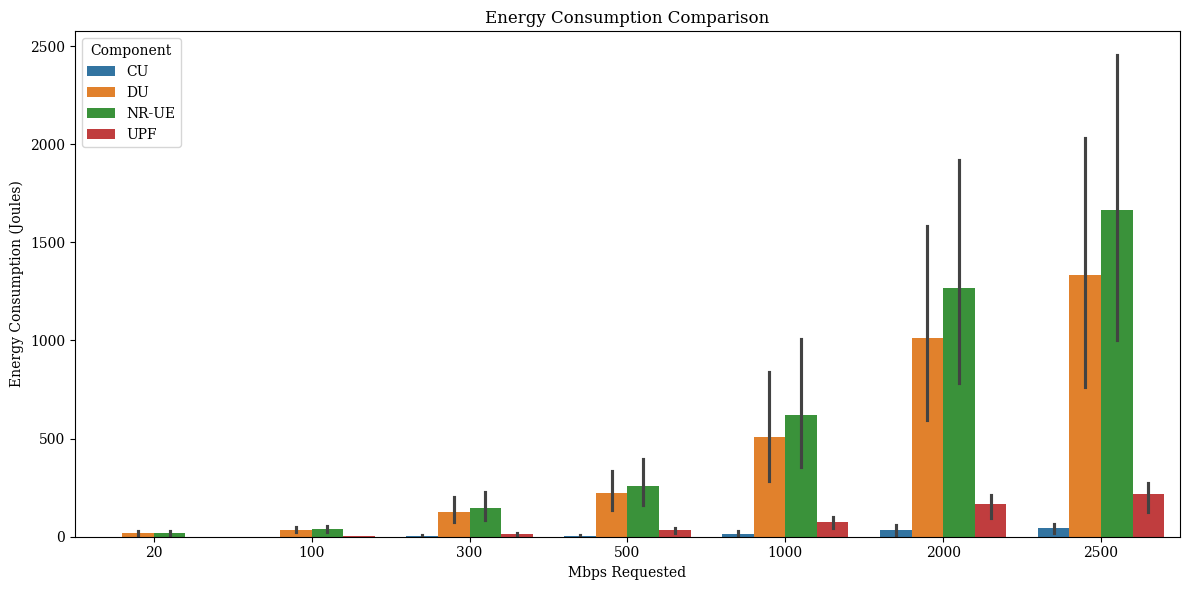

In [21]:
# Energy Consumption Comparison
def plot_energy_comparison(df_experiment):
    plt.figure(figsize=(12, 6))
    
    components = [
        'total OAI-CU energy consumption [J]', 
        'total OAI-DU energy consumption [J]',
        'total OAI-NR-UE energy consumption [J]', 
        'total OAI-UPF energy consumption [J]'
    ]
    
    # Filter and melt the data for easier plotting
    df_melted = df_experiment.melt(
        id_vars=['Mbps requested', 'num_cus'], 
        value_vars=components, 
        var_name='Component', 
        value_name='Energy (J)'
    )
    
    # Replace component names for clarity
    df_melted['Component'] = df_melted['Component'].str.replace(
        'total OAI-', ''
    ).str.replace(' energy consumption \\[J\\]', '', regex=True)
    
    sns.barplot(
        data=df_melted, 
        x='Mbps requested', 
        y='Energy (J)', 
        hue='Component'
    )
    
    plt.title('Energy Consumption Comparison')
    plt.xlabel('Mbps Requested')
    plt.ylabel('Energy Consumption (Joules)')
    plt.legend(title='Component')
    plt.tight_layout()
    plt.show()

plot_energy_comparison(df_experiment)


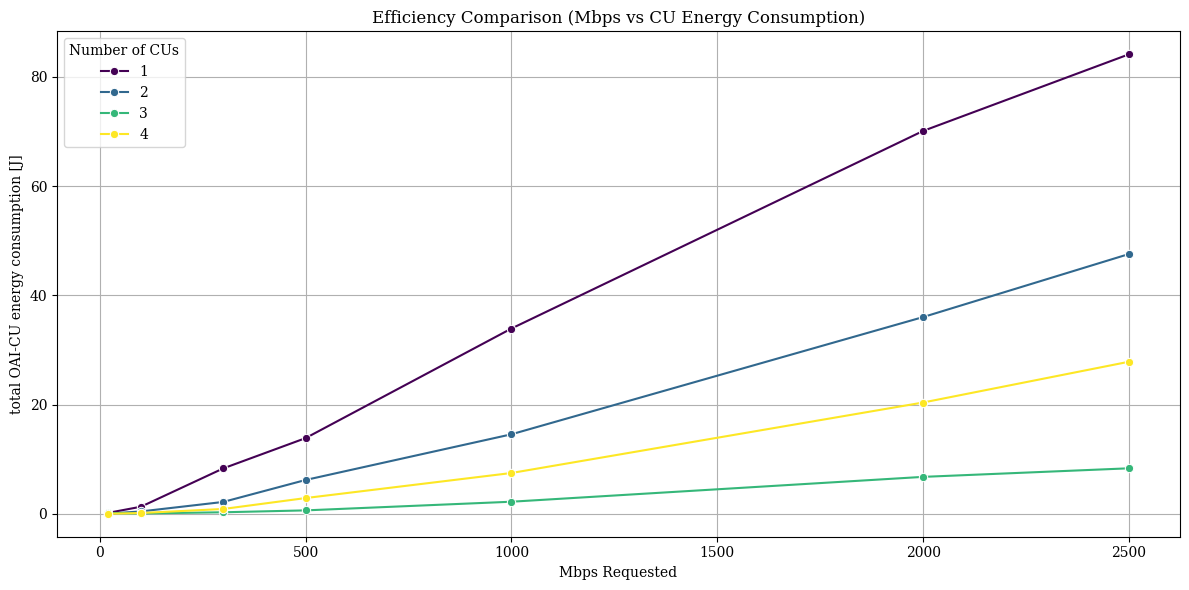

In [22]:
# Efficiency Plot
def plot_efficiency(df_experiment):
    plt.figure(figsize=(12, 6))
    
    sns.lineplot(
        data=df_experiment, 
        x='Mbps requested', 
        y='total OAI-CU energy consumption [J]', 
        hue='num_cus', 
        marker='o', 
        palette='viridis'
    )
    
    plt.title('Efficiency Comparison (Mbps vs CU Energy Consumption)')
    plt.xlabel('Mbps Requested')
    plt.ylabel('total OAI-CU energy consumption [J]')
    plt.legend(title='Number of CUs', loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the functions to plot
plot_efficiency(df_experiment)


In [23]:
df_experiment

,Mbps requested,packet length requested,tot Mbps effectively received at server,avg OAI-CU power consumption [W],total OAI-CU energy consumption [J],avg OAI-DU power consumption [W],total OAI-DU energy consumption [J],avg OAI-NR-UE power consumption [W],total OAI-NR-UE energy consumption [J],avg OAI-UPF power consumption [W],total OAI-UPF energy consumption [J],duration_1,duration_2,duration_3,duration_4,maxrate,num_cus
0,1000,500,1048.57600,0.046225,2.216664,5.778813,272.149971,6.666526,314.272713,0.541213,25.248314,47.5,94.9,84.6,47.5,50,3
1,100,500,104.85760,0.017800,0.067820,5.743125,22.992644,6.275355,24.807756,0.189323,0.473308,4.8,4.8,9.5,7.3,50,3
2,500,500,524.28800,0.026733,0.630992,5.733011,131.823737,6.087984,140.172742,0.526866,12.062385,47.5,44.6,23.7,23.7,50,3
3,2000,500,2097.15200,0.071308,6.764211,5.895125,554.214281,6.975400,656.020200,0.648547,60.619681,180.0,94.9,189.8,94.8,50,3
4,20,500,20.97152,0.025346,0.139404,5.852447,32.188460,6.214370,34.179035,0.000000,0.000000,1.9,1.0,1.6,1.0,50,3
5,300,500,314.57280,0.022407,0.284043,5.836597,75.858312,6.366992,82.526177,0.351301,4.644976,14.3,28.5,22.0,14.3,50,3
6,2500,500,2621.44000,0.070284,8.331919,6.071246,716.678252,7.022511,829.196947,0.632166,74.813823,234.8,237.3,118.6,118.6,50,3
7,1000,500,1048.57600,0.202469,33.912938,6.123666,1022.675079,7.242177,1209.360619,0.599573,100.413802,168.1,178.4,190.1,188.0,50,1
8,100,500,104.85760,0.132578,1.298011,5.714042,57.359012,6.125009,61.623884,0.331351,3.224393,19.0,18.5,11.4,18.5,50,1
9,500,500,524.28800,0.202334,13.856754,5.897381,401.126676,6.816509,463.751307,0.575048,39.352186,95.0,84.4,68.9,92.6,50,1


In [24]:
# Constants previously calculated
host_power_w = 3.19440272256247
activation_duration=15.790528904307973
activation_power=8.69440272256247

# Calculate host energy consumption for each CU configuration dynamically
# this depends on how you connect the DUs to the CUs
df_experiment['host_energy_consumption'] = df_experiment.apply(
    lambda row: (
        host_power_w * (
            max(row[f'duration_{i}'] for i in range(1, int(row['num_cus']) + 1))  if row['num_cus'] == 1# For single CU
            else (max(row[f'duration_3'],row[f'duration_4']) + max(row[f'duration_1'], row[f'duration_2'] )) if row['num_cus'] == 2
            else (max(row[f'duration_3'],row[f'duration_4']) + row[f'duration_1'] + row[f'duration_2'] ) if row['num_cus'] == 3
            else sum(row[f'duration_{i}'] for i in range(1, int(row['num_cus']) + 1))  # For multiple CUs
        )
    ),
    axis=1
)


df_experiment['powerup_energy_consumption'] = activation_power * activation_duration *  (df_experiment['num_cus'] - 1)
#powerup_energy *  df_experiment['num_cus'] 


# Calculate the total energy consumption for each row (sum of all energy consumption columns)
df_experiment['service_energy_consumption_J'] = (
    df_experiment['total OAI-CU energy consumption [J]'] +
    df_experiment['total OAI-DU energy consumption [J]']# +
    # df_experiment['total OAI-UPF energy consumption [J]']
)

# Calculate the total energy consumption
df_experiment['total_energy_consumption'] = df_experiment.apply(
    lambda row: (
        row['service_energy_consumption_J'] + 
        row['host_energy_consumption'] +
        (row['powerup_energy_consumption'] if row['num_cus'] > 1 else 0)  # Power-up applies only for >1 CU
    ),
    axis=1
)

In [25]:
df_experiment.columns
df_experiment.to_csv('/home/pow_cons/power-consumption-tool/power-metrics-per-pod-realtime/data/experiment_results.csv', index=False)

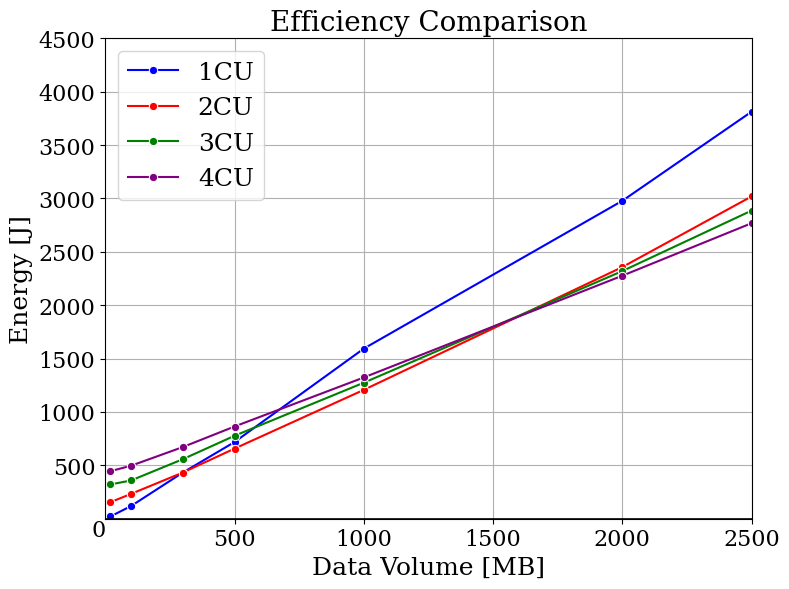

In [26]:
def plot_efficiency(df_experiment):
    # Ensure the output folder exists
    output_dir = "output_plots"
    os.makedirs(output_dir, exist_ok=True)
    
    plt.figure(figsize=(8, 6))
    
    sns.lineplot(
        data=df_experiment, 
        x='Mbps requested', 
        y='total_energy_consumption', 
        hue='num_cus', 
        marker='o', 
        palette=['blue', 'red', 'green', 'purple'],
        errorbar=None  # Disables the standard deviation shading
    )
    
    plt.title('Efficiency Comparison', fontsize=20)
    plt.xlabel('Data Volume [MB]', fontsize=18)
    plt.ylabel('Energy [J]', fontsize=18)
    
    # Ensure axes coincide at (0,0) and set x-axis limit
    plt.xlim(0, 2500)  # Limit x-axis to a max of 2500
    plt.ylim(bottom=0)  # Ensure y-axis starts from 0

    # Set x and y axis ticks, ensuring (0,0) appears only once
    x_ticks = plt.xticks()[0]  # Get current x-axis ticks
    y_ticks = plt.yticks()[0]  # Get current y-axis ticks

    # Remove duplicate zero from ticks if present
    x_ticks = [tick for tick in x_ticks if tick > 0]  # Remove duplicate zero
    y_ticks = [tick for tick in y_ticks if tick > 0]

    plt.xticks(x_ticks, fontsize=16)
    plt.yticks(y_ticks, fontsize=16)
    
    # Custom legend labels
    custom_legend_labels = ['1CU', '2CU', '3CU', '4CU']
    plt.legend(custom_legend_labels, fontsize=18)    
    
    # Add grid and axis styling
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=1.2)  # Bold x-axis at zero
    plt.axvline(0, color='black', linewidth=1.2)  # Bold y-axis at zero

    # Add a single "0" in the bottom-left corner diagonally
    plt.text(0, 0, '0', fontsize=16, ha='right', va='top', transform=plt.gca().transData)

    plt.tight_layout()
    
    # Save the plot to a PDF file
    output_file = os.path.join(output_dir, "policy_plot.pdf")
    plt.savefig(output_file, format='pdf')
    plt.show()

# Call the function to plot and save
plot_efficiency(df_experiment)


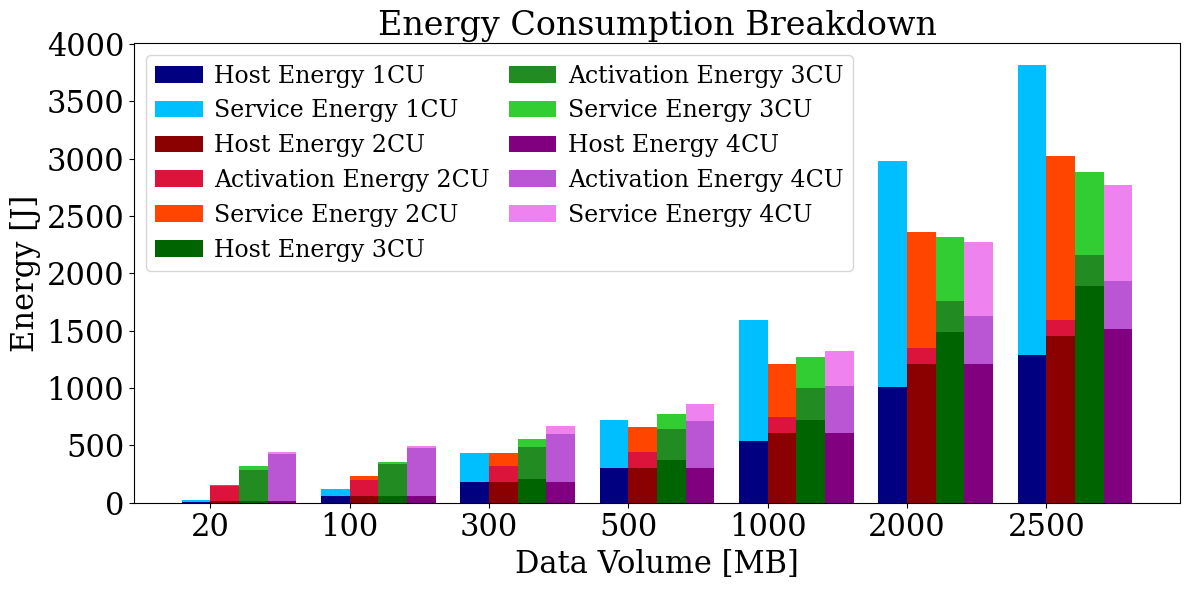

In [27]:
# Filter the DataFrame for a specific maxrate value
maxrate = 50  # Replace with the desired maxrate value
df = df_experiment[df_experiment['maxrate'] == maxrate].copy()

# Aggregate the data for each Mbps requested and num_cus combination
energy_data = df.groupby(['Mbps requested', 'num_cus'])[
    ['host_energy_consumption', 'service_energy_consumption_J', 'powerup_energy_consumption']
].mean().unstack()

# Define color mapping for bars
color_map = {
    1: ['navy', 'deepskyblue', 'dodgerblue'],        # Higher contrast blues for 1 CU
    2: ['darkred', 'orangered', 'crimson'],          # Higher contrast reds for 2 CUs
    3: ['darkgreen', 'limegreen', 'forestgreen'],    # Higher contrast greens for 3 CUs
    4: ['purple', 'violet', 'mediumorchid'],         # Higher contrast purples for 4 CUs
}

# Calculate x positions for bars
bar_width = 0.35
bar_gap = 1  # Space between groups
x_positions = np.arange(len(energy_data.index)) * (2 * bar_width + bar_gap)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each CU configuration
for j, num_cus in enumerate(energy_data.columns.levels[1]):
    # Extract data for the specific num_cus
    data = energy_data.xs(num_cus, level='num_cus', axis=1)
    
    # Plot Host Energy Consumption
    ax.bar(
        x_positions + j * bar_width,
        data['host_energy_consumption'],
        width=bar_width,
        color=color_map[num_cus][0],
        label=f'Host Energy {num_cus}CU',  # Only label once
    )
    
    # Plot Power-Up Energy Consumption for num_cus > 1
    if num_cus > 1:
        ax.bar(
            x_positions + j * bar_width,
            data['powerup_energy_consumption'],
            width=bar_width,
            bottom=data['host_energy_consumption'],
            color=color_map[num_cus][2],  # Use the third color for Power-Up Energy
            label=f'Activation Energy {num_cus}CU',  # Only label once
        )
    
    # Plot Service Energy Consumption
    ax.bar(
        x_positions + j * bar_width,
        data['service_energy_consumption_J'],
        width=bar_width,
        bottom=data['host_energy_consumption'] + (data['powerup_energy_consumption'] if num_cus > 1 else 0),
        color=color_map[num_cus][1],  # Use the second color for Service Energy
        label=f'Service Energy {num_cus}CU',  # Only label once
    )

# Add labels, title, and legend with increased font size
ax.set_xlabel('Data Volume [MB]', fontsize=22)  # Increased font size for x-axis label
ax.set_ylabel('Energy [J]', fontsize=22)  # Increased font size for y-axis label
ax.set_title(f'Energy Consumption Breakdown', fontsize=24)  # Increased title font size

# Increase font size for ticks on both axes
plt.xticks(fontsize=22)  # Larger font size for x-axis ticks
plt.yticks(fontsize=22)  # Larger font size for y-axis ticks

# Set x-ticks and labels
ax.set_xticks(x_positions + bar_width / 2)
ax.set_xticklabels(energy_data.index, rotation=0)

# Adjust legend font size
# Adjust the legend to be more compact
ax.legend(fontsize=17, ncol=2, loc='upper left', columnspacing=0.8, handletextpad=0.5)


# Adjust layout for better spacing
plt.tight_layout()

# Save the plot to a PDF file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "energy_details_plot.pdf")
plt.savefig(output_file, format='pdf')

# Display the plot
plt.show()


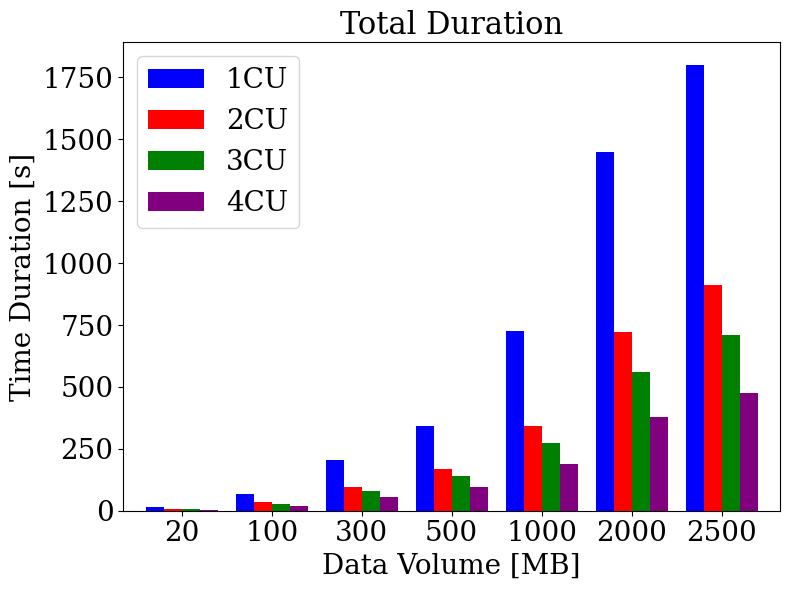

In [28]:
# Filter the DataFrame for a specific maxrate value
maxrate = 50  # Replace with the desired maxrate value
df = df_experiment[df_experiment['maxrate'] == maxrate].copy()

# Dynamically calculate total duration based on available duration columns
duration_columns = ['duration_1', 'duration_2', 'duration_3', 'duration_4']
existing_duration_cols = [col for col in duration_columns if col in df.columns]
df['total_duration'] = df[existing_duration_cols].sum(axis=1)
# Aggregate the data for each Mbps requested and num_cus combination
bar_data_with_host = df.groupby(['Mbps requested', 'num_cus'])['total_duration'].mean().unstack()

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
bar_data_with_host.plot(kind='bar', ax=ax, width=0.8, color=['blue', 'red', 'green', 'purple'])

# Add labels, title, and legend with increased font size
ax.set_xlabel('Data Volume [MB]', fontsize=20)  # Increased font size for x-axis label
ax.set_ylabel('Time Duration [s]', fontsize=20)  # Increased font size for y-axis label
ax.set_title(f'Total Duration', fontsize=22)  # Increased title font size

# Increase font size for ticks on both axes
plt.xticks(fontsize=20)  # Larger font size for x-axis ticks
plt.yticks(fontsize=20)  # Larger font size for y-axis ticks

# Set x-ticks and labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

custom_legend_labels = ['1CU', '2CU', '3CU', '4CU']
ax.legend(custom_legend_labels, fontsize=20)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot to a PDF file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "durations_plot.pdf")
plt.savefig(output_file, format='pdf')

# Display the plot
plt.show()


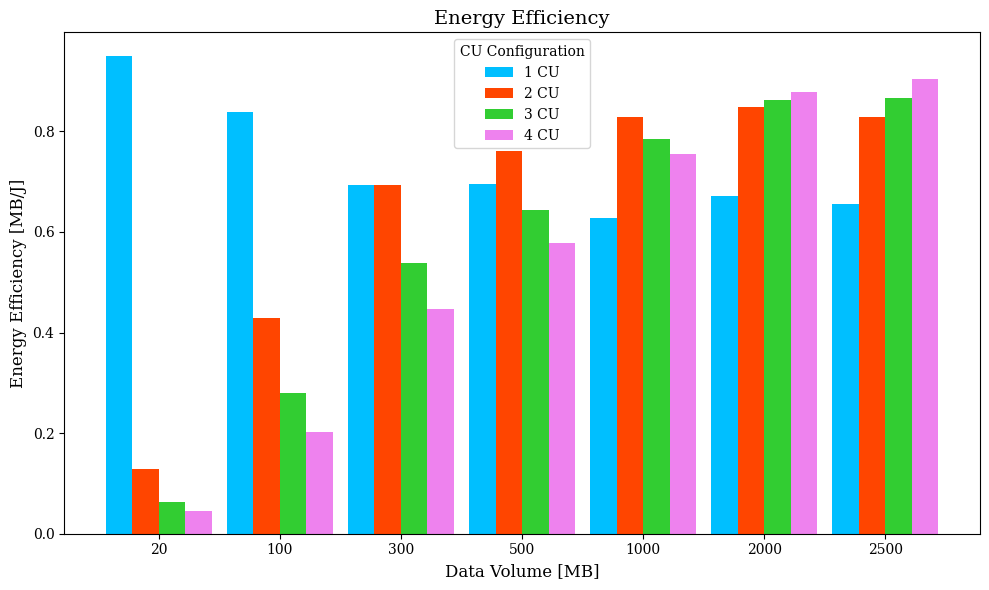

In [29]:
# Filter the DataFrame for a specific maxrate value
maxrate = 50  # Replace with the desired maxrate value
df = df_experiment[df_experiment['maxrate'] == maxrate].copy()

# Aggregate the data for each Mbps requested and num_cus combination
aggregated_data = df.groupby(['Mbps requested', 'num_cus'])[
    ['host_energy_consumption', 'service_energy_consumption_J', 'powerup_energy_consumption']
].mean()

# Calculate total energy consumption
aggregated_data['total_energy'] = (
    aggregated_data['host_energy_consumption'] +
    aggregated_data['service_energy_consumption_J'] +
    aggregated_data['powerup_energy_consumption']
)

# Calculate energy efficiency (Mbps requested / total energy)
aggregated_data['energy_efficiency'] = (
    aggregated_data.index.get_level_values(0) / aggregated_data['total_energy']
)

# Unstack the data for easier plotting
efficiency_data = aggregated_data['energy_efficiency'].unstack()

# Define color mapping for bars
color_map = {
    1: 'deepskyblue',  # Color for 1 CU
    2: 'orangered',    # Color for 2 CUs
    3: 'limegreen',    # Color for 3 CUs
    4: 'violet'        # Color for 4 CUs
}

# Calculate x positions with added gaps
bar_width = 0.35
x_positions = np.arange(len(efficiency_data.index)) * (bar_width * len(efficiency_data.columns) + 0.2)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for each CU configuration
for j, num_cus in enumerate(efficiency_data.columns):
    ax.bar(
        x_positions + j * bar_width,
        efficiency_data[num_cus],
        width=bar_width,
        color=color_map[num_cus],
        label=f'{num_cus} CU'
    )

# Add labels, title, and legend
ax.set_xlabel('Data Volume [MB]', fontsize=12)
ax.set_ylabel('Energy Efficiency [MB/J]', fontsize=12)
ax.set_title(f'Energy Efficiency', fontsize=14)
ax.set_xticks(x_positions + (len(efficiency_data.columns) - 1) * bar_width / 2)
ax.set_xticklabels(efficiency_data.index, rotation=0)
ax.legend(title='CU Configuration')

# Adjust layout
plt.tight_layout()

# Save the plot to a PDF file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "energy_efficiency_barplot.pdf")
plt.savefig(output_file, format='pdf')

plt.show()


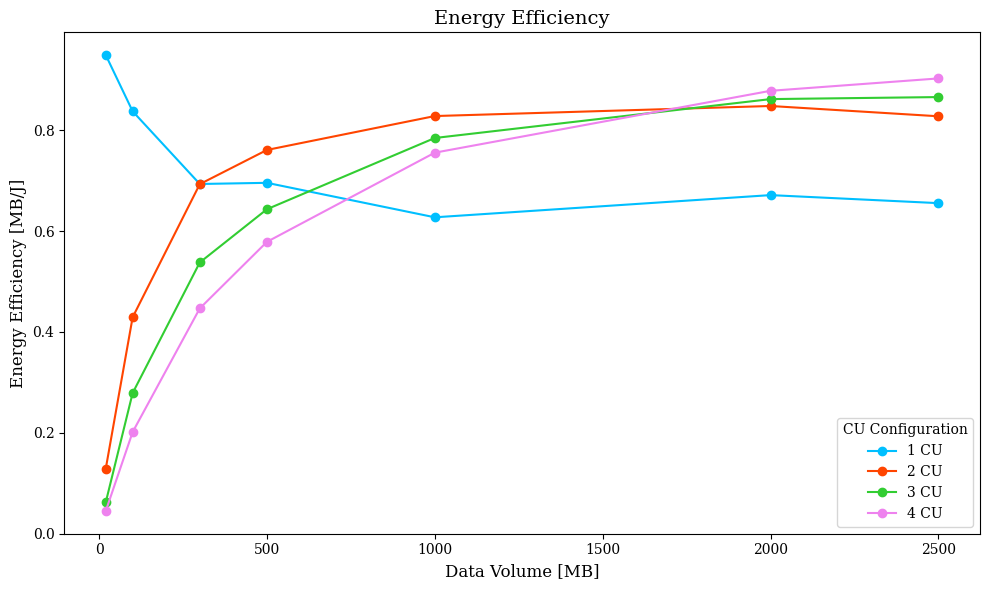

In [30]:
# Filter the DataFrame for a specific maxrate value
maxrate = 50  # Replace with the desired maxrate value
df = df_experiment[df_experiment['maxrate'] == maxrate].copy()

# Aggregate the data for each Mbps requested and num_cus combination
aggregated_data = df.groupby(['Mbps requested', 'num_cus'])[
    ['host_energy_consumption', 'service_energy_consumption_J', 'powerup_energy_consumption']
].mean()

# Calculate total energy consumption
aggregated_data['total_energy'] = (
    aggregated_data['host_energy_consumption'] +
    aggregated_data['service_energy_consumption_J'] +
    aggregated_data['powerup_energy_consumption']
)

# Calculate energy efficiency (Mbps requested / total energy)
aggregated_data['energy_efficiency'] = (
    aggregated_data.index.get_level_values(0) / aggregated_data['total_energy']
)

# Unstack the data for easier plotting
efficiency_data = aggregated_data['energy_efficiency'].unstack()

# Define color mapping for lines
color_map = {
    1: 'deepskyblue',  # Color for 1 CU
    2: 'orangered',    # Color for 2 CUs
    3: 'limegreen',    # Color for 3 CUs
    4: 'violet'        # Color for 4 CUs
}

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lines for each CU configuration
for num_cus in efficiency_data.columns:
    ax.plot(
        efficiency_data.index,  # X values (MB Requested)
        efficiency_data[num_cus],  # Y values (Energy Efficiency)
        marker='o',
        color=color_map[num_cus],
        label=f'{num_cus} CU'
    )

# Add labels, title, and legend
ax.set_xlabel('Data Volume [MB]', fontsize=12)
ax.set_ylabel('Energy Efficiency [MB/J]', fontsize=12)
ax.set_title(f'Energy Efficiency', fontsize=14)
ax.legend(title='CU Configuration')

# Adjust layout
plt.tight_layout()

# Save the plot to a PDF file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "energy_efficiency_lineplot.pdf")
plt.savefig(output_file, format='pdf')

plt.show()
